# Notebook 04 — Retention & Cohort Analysis

Goal:
- Measure retention after adoption (first purchase)
- Build monthly cohorts based on first purchase month
- Compare retention across markets, channels, and product tiers
- Identify segments with better long-term engagement

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 4)

In [2]:
DATA_DIR = Path("../data/raw")

patients = pd.read_csv(DATA_DIR / "patients.csv")
tx = pd.read_csv(DATA_DIR / "transactions.csv", parse_dates=["tx_date"])

patients.shape, tx.shape

((50000, 6), (70024, 8))

In [3]:
tx = tx.copy()

tx["tx_month"] = tx["tx_date"].dt.to_period("M").dt.to_timestamp()
tx["revenue"] = tx["price"] * tx["quantity"]

tx.head()

,tx_id,patient_id,tx_date,category,product_tier,price,quantity,channel,tx_month,revenue
0,1,1,2024-10-29,contacts,value,20.26,1,clinic,2024-10-01,20.26
1,2,1,2024-11-29,contacts,value,16.78,2,clinic,2024-11-01,33.56
2,3,1,2025-01-06,contacts,value,15.67,2,clinic,2025-01-01,31.34
3,4,1,2025-02-09,contacts,value,18.08,1,clinic,2025-02-01,18.08
4,5,2,2025-11-07,drops,value,8.23,2,retail,2025-11-01,16.46


In [4]:
first_purchase = (
    tx.groupby("patient_id", as_index=False)["tx_month"]
      .min()
      .rename(columns={"tx_month": "cohort_month"})
)

first_purchase.head()

,patient_id,cohort_month
0,1,2024-10-01
1,2,2025-11-01
2,3,2024-08-01
3,5,2025-09-01
4,12,2025-01-01


In [5]:
txc = (
    tx.merge(first_purchase, on="patient_id", how="left")
      .merge(patients[["patient_id", "market_type"]], on="patient_id", how="left")
)

txc["cohort_index"] = (
    (txc["tx_month"].dt.year - txc["cohort_month"].dt.year) * 12
    + (txc["tx_month"].dt.month - txc["cohort_month"].dt.month)
)

txc[["patient_id", "tx_date", "tx_month", "cohort_month", "cohort_index", "channel", "product_tier", "market_type"]].head()

,patient_id,tx_date,tx_month,cohort_month,cohort_index,channel,product_tier,market_type
0,1,2024-10-29,2024-10-01,2024-10-01,0,clinic,value,emerging
1,1,2024-11-29,2024-11-01,2024-10-01,1,clinic,value,emerging
2,1,2025-01-06,2025-01-01,2024-10-01,3,clinic,value,emerging
3,1,2025-02-09,2025-02-01,2024-10-01,4,clinic,value,emerging
4,2,2025-11-07,2025-11-01,2025-11-01,0,retail,value,developed


In [6]:
txc = (
    tx.merge(first_purchase, on="patient_id", how="left")
      .merge(patients[["patient_id", "market_type"]], on="patient_id", how="left")
)

txc["cohort_index"] = (
    (txc["tx_month"].dt.year - txc["cohort_month"].dt.year) * 12
    + (txc["tx_month"].dt.month - txc["cohort_month"].dt.month)
)

txc[["patient_id", "tx_date", "tx_month", "cohort_month", "cohort_index", "channel", "product_tier", "market_type"]].head()

,patient_id,tx_date,tx_month,cohort_month,cohort_index,channel,product_tier,market_type
0,1,2024-10-29,2024-10-01,2024-10-01,0,clinic,value,emerging
1,1,2024-11-29,2024-11-01,2024-10-01,1,clinic,value,emerging
2,1,2025-01-06,2025-01-01,2024-10-01,3,clinic,value,emerging
3,1,2025-02-09,2025-02-01,2024-10-01,4,clinic,value,emerging
4,2,2025-11-07,2025-11-01,2025-11-01,0,retail,value,developed


In [7]:
cohort_counts = (
    txc.groupby(["cohort_month", "cohort_index"])["patient_id"]
       .nunique()
       .reset_index(name="active_patients")
)

cohort_sizes = (
    txc[txc["cohort_index"] == 0]
    .groupby("cohort_month")["patient_id"]
    .nunique()
    .reset_index(name="cohort_size")
)

cohort = cohort_counts.merge(cohort_sizes, on="cohort_month", how="left")
cohort["retention"] = cohort["active_patients"] / cohort["cohort_size"]

cohort.head()

,cohort_month,cohort_index,active_patients,cohort_size,retention
0,2024-01-01,0,861,861,1.000000
1,2024-01-01,1,539,861,0.626016
2,2024-01-01,2,472,861,0.548200
3,2024-01-01,3,316,861,0.367015
4,2024-01-01,4,182,861,0.211382


In [9]:
retention_matrix = cohort.pivot_table(
    index="cohort_month",
    columns="cohort_index",
    values="retention"
).sort_index()

retention_matrix.head()

cohort_index,0,1,2,3,4,5,6
cohort_month,,,,,,,
2024-01-01,1.0,0.626016,0.548200,0.367015,0.211382,0.077816,0.001161
2024-02-01,1.0,0.658009,0.551948,0.380952,0.177489,0.072511,0.002165
2024-03-01,1.0,0.652174,0.562319,0.355556,0.202899,0.073430,0.000966
2024-04-01,1.0,0.693811,0.509229,0.362649,0.201954,0.069490,0.002172
2024-05-01,1.0,0.637051,0.556711,0.380907,0.179584,0.081285,NaN


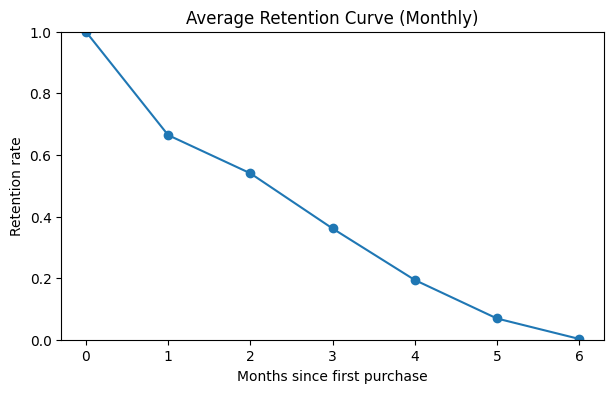

In [10]:
avg_retention = retention_matrix.mean(axis=0)

avg_retention.plot(marker="o")
plt.title("Average Retention Curve (Monthly)")
plt.xlabel("Months since first purchase")
plt.ylabel("Retention rate")
plt.ylim(0, 1)
plt.show()

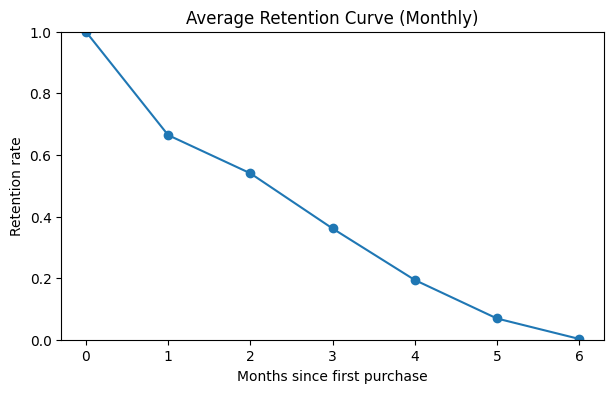

In [11]:
avg_retention = retention_matrix.mean(axis=0)

avg_retention.plot(marker="o")
plt.title("Average Retention Curve (Monthly)")
plt.xlabel("Months since first purchase")
plt.ylabel("Retention rate")
plt.ylim(0, 1)
plt.show()

In [12]:
def retention_by_segment(df, segment_col, top_n=6):
    # choose largest segments by cohort-0 patient count
    base = (
        df[df["cohort_index"] == 0]
        .groupby(segment_col)["patient_id"]
        .nunique()
        .sort_values(ascending=False)
        .head(top_n)
        .index
    )

    d = df[df[segment_col].isin(base)].copy()

    counts = (
        d.groupby([segment_col, "cohort_index"])["patient_id"]
         .nunique()
         .reset_index(name="active_patients")
    )

    sizes = (
        d[d["cohort_index"] == 0]
        .groupby(segment_col)["patient_id"]
        .nunique()
        .reset_index(name="cohort_size")
    )

    out = counts.merge(sizes, on=segment_col, how="left")
    out["retention"] = out["active_patients"] / out["cohort_size"]
    return out

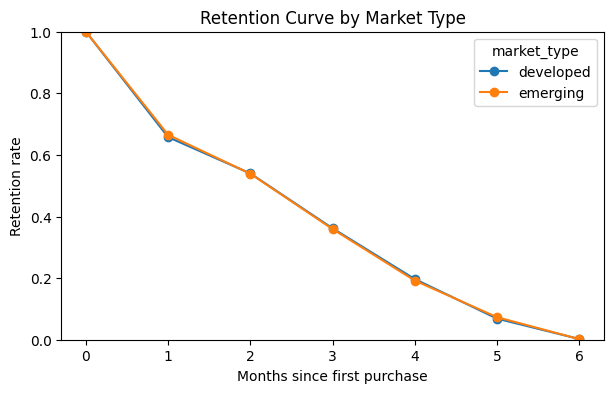

In [13]:
seg_market = retention_by_segment(txc, "market_type", top_n=10)

market_curve = seg_market.pivot_table(
    index="cohort_index",
    columns="market_type",
    values="retention"
).sort_index()

market_curve.plot(marker="o")
plt.title("Retention Curve by Market Type")
plt.xlabel("Months since first purchase")
plt.ylabel("Retention rate")
plt.ylim(0, 1)
plt.show()

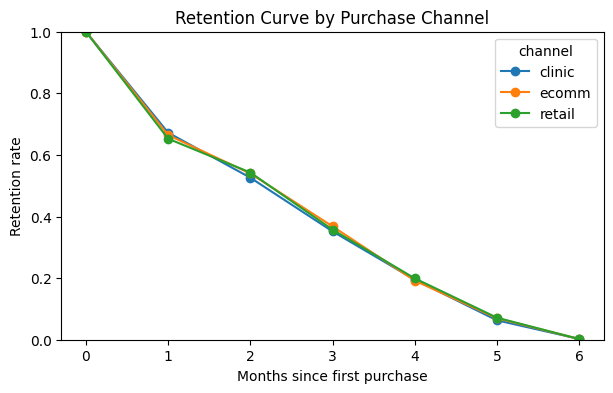

In [14]:
seg_channel = retention_by_segment(txc, "channel", top_n=10)

channel_curve = seg_channel.pivot_table(
    index="cohort_index",
    columns="channel",
    values="retention"
).sort_index()

channel_curve.plot(marker="o")
plt.title("Retention Curve by Purchase Channel")
plt.xlabel("Months since first purchase")
plt.ylabel("Retention rate")
plt.ylim(0, 1)
plt.show()

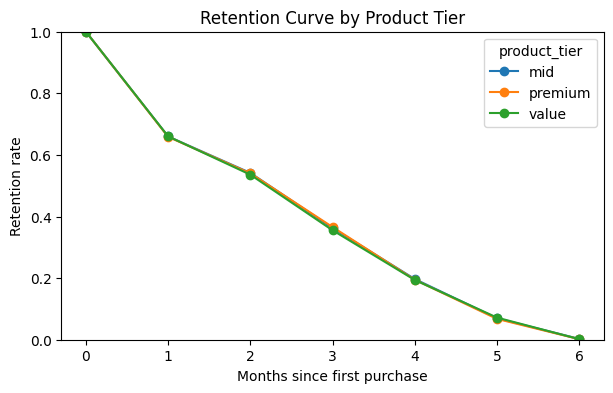

In [15]:
seg_tier = retention_by_segment(txc, "product_tier", top_n=10)

tier_curve = seg_tier.pivot_table(
    index="cohort_index",
    columns="product_tier",
    values="retention"
).sort_index()

tier_curve.plot(marker="o")
plt.title("Retention Curve by Product Tier")
plt.xlabel("Months since first purchase")
plt.ylabel("Retention rate")
plt.ylim(0, 1)
plt.show()

In [16]:
def retention_kpis(curve_series):
    # curve_series: index = month number
    k = {}
    k["M1"] = float(curve_series.get(1, np.nan))
    k["M3"] = float(curve_series.get(3, np.nan))
    k["M6"] = float(curve_series.get(6, np.nan))
    return k

kpis = retention_kpis(avg_retention)
kpis

{'M1': 0.6643340860737972,
 'M3': 0.36121565737615735,
 'M6': 0.002596142884231424}

## Key Retention Insights (Draft)

- Cohort analysis shows how engagement evolves after the first purchase (adoption).
- Retention typically drops after month 0 and stabilizes over time, indicating a natural churn pattern.
- Differences by market type may reflect access, follow-up care availability, and affordability.
- Channel-level retention highlights which distribution paths lead to more sustained engagement.
- Product tier retention can indicate long-term value differences (e.g., premium users may churn less or repurchase more).

Next step: translate these patterns into business actions (follow-up reminders, channel strategy, pricing/tier positioning).